In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# ***Step 1: Load All Telco Churn Tables***

In [3]:
import os
import pandas as pd

folder = "/kaggle/input/telco-customer-churn-1113/"

demographics = pd.read_excel(folder + "Telco_customer_churn_demographics.xlsx")
location = pd.read_excel(folder + "Telco_customer_churn_location.xlsx")
population = pd.read_excel(folder + "Telco_customer_churn_population.xlsx")
services = pd.read_excel(folder + "Telco_customer_churn_services.xlsx")
status = pd.read_excel(folder + "Telco_customer_churn_status.xlsx")

print("Loaded all tables successfully.\n")

print("Demographics:", demographics.shape)
print("Location:", location.shape)
print("Population:", population.shape)
print("Services:", services.shape)
print("Status:", status.shape)

demographics.head()


Loaded all tables successfully.

Demographics: (7043, 9)
Location: (7043, 9)
Population: (1671, 3)
Services: (7043, 30)
Status: (7043, 11)


,Customer ID,Count,Gender,Age,Under 30,Senior Citizen,Married,Dependents,Number of Dependents
0,8779-QRDMV,1,Male,78,No,Yes,No,No,0
1,7495-OOKFY,1,Female,74,No,Yes,Yes,Yes,1
2,1658-BYGOY,1,Male,71,No,Yes,No,Yes,3
3,4598-XLKNJ,1,Female,78,No,Yes,Yes,Yes,1
4,4846-WHAFZ,1,Female,80,No,Yes,Yes,Yes,1


# ***Step 2: Inspect Tables and Define Join Relationships***

In [2]:
print("Demographics columns:\n", demographics.columns, "\n")
print("Location columns:\n", location.columns, "\n")
print("Population columns:\n", population.columns, "\n")
print("Services columns:\n", services.columns, "\n")
print("Status columns:\n", status.columns, "\n")


Demographics columns:
 Index(['Customer ID', 'Count', 'Gender', 'Age', 'Under 30', 'Senior Citizen',
       'Married', 'Dependents', 'Number of Dependents'],
      dtype='object') 

Location columns:
 Index(['Customer ID', 'Count', 'Country', 'State', 'City', 'Zip Code',
       'Lat Long', 'Latitude', 'Longitude'],
      dtype='object') 

Population columns:
 Index(['ID', 'Zip Code', 'Population'], dtype='object') 

Services columns:
 Index(['Customer ID', 'Count', 'Quarter', 'Referred a Friend',
       'Number of Referrals', 'Tenure in Months', 'Offer', 'Phone Service',
       'Avg Monthly Long Distance Charges', 'Multiple Lines',
       'Internet Service', 'Internet Type', 'Avg Monthly GB Download',
       'Online Security', 'Online Backup', 'Device Protection Plan',
       'Premium Tech Support', 'Streaming TV', 'Streaming Movies',
       'Streaming Music', 'Unlimited Data', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charge', 'Total Charges', 'Total Refunds',

# ***Step 3: Clean Column Names and Prepare for SQL Loading***


In [4]:
def clean_columns(df):
    df = df.copy()
    df.columns = (
        df.columns
        .str.replace(" ", "_")
        .str.replace("-", "_")
        .str.replace("/", "_")
        .str.strip()
    )
    return df

demographics_c = clean_columns(demographics)
location_c = clean_columns(location)
population_c = clean_columns(population)
services_c = clean_columns(services)
status_c = clean_columns(status)

demographics_c.columns, location_c.columns, services_c.columns, status_c.columns


(Index(['Customer_ID', 'Count', 'Gender', 'Age', 'Under_30', 'Senior_Citizen',
        'Married', 'Dependents', 'Number_of_Dependents'],
       dtype='object'),
 Index(['Customer_ID', 'Count', 'Country', 'State', 'City', 'Zip_Code',
        'Lat_Long', 'Latitude', 'Longitude'],
       dtype='object'),
 Index(['Customer_ID', 'Count', 'Quarter', 'Referred_a_Friend',
        'Number_of_Referrals', 'Tenure_in_Months', 'Offer', 'Phone_Service',
        'Avg_Monthly_Long_Distance_Charges', 'Multiple_Lines',
        'Internet_Service', 'Internet_Type', 'Avg_Monthly_GB_Download',
        'Online_Security', 'Online_Backup', 'Device_Protection_Plan',
        'Premium_Tech_Support', 'Streaming_TV', 'Streaming_Movies',
        'Streaming_Music', 'Unlimited_Data', 'Contract', 'Paperless_Billing',
        'Payment_Method', 'Monthly_Charge', 'Total_Charges', 'Total_Refunds',
        'Total_Extra_Data_Charges', 'Total_Long_Distance_Charges',
        'Total_Revenue'],
       dtype='object'),
 Index(['C

In [5]:
demographics_c = demographics_c.rename(columns={"Customer_ID": "CustomerID"})
location_c = location_c.rename(columns={"Customer_ID": "CustomerID"})
services_c = services_c.rename(columns={"Customer_ID": "CustomerID"})
status_c = status_c.rename(columns={"Customer_ID": "CustomerID"})

population_c = population_c.rename(columns={"Zip_Code": "ZipCode"})
location_c = location_c.rename(columns={"ZipCode": "ZipCode"})  # in case it already got renamed


In [6]:
import sqlite3

db_path = "/kaggle/working/telco_churn.db"
conn = sqlite3.connect(db_path)

demographics_c.to_sql("Demographics", conn, if_exists="replace", index=False)
location_c.to_sql("Location", conn, if_exists="replace", index=False)
population_c.to_sql("Population", conn, if_exists="replace", index=False)
services_c.to_sql("Services", conn, if_exists="replace", index=False)
status_c.to_sql("Status", conn, if_exists="replace", index=False)

print("SQL Database created and all 5 tables loaded.")


SQL Database created and all 5 tables loaded.


In [7]:
pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)


,name
0,Demographics
1,Location
2,Population
3,Services
4,Status


# ***Step 4: Run SQL Joins and SQL Exploratory Analysis***


In [12]:
pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)


,name
0,Demographics
1,Location
2,Population
3,Services
4,Status


In [13]:
print("Demographics columns:")
display(pd.read_sql("PRAGMA table_info(Demographics);", conn))

print("Location columns:")
display(pd.read_sql("PRAGMA table_info(Location);", conn))

print("Population columns:")
display(pd.read_sql("PRAGMA table_info(Population);", conn))

print("Services columns:")
display(pd.read_sql("PRAGMA table_info(Services);", conn))

print("Status columns:")
display(pd.read_sql("PRAGMA table_info(Status);", conn))


Demographics columns:


,cid,name,type,notnull,dflt_value,pk
0,0,CustomerID,TEXT,0,None,0
1,1,Count,INTEGER,0,None,0
2,2,Gender,TEXT,0,None,0
3,3,Age,INTEGER,0,None,0
4,4,Under_30,TEXT,0,None,0
5,5,Senior_Citizen,TEXT,0,None,0
6,6,Married,TEXT,0,None,0
7,7,Dependents,TEXT,0,None,0
8,8,Number_of_Dependents,INTEGER,0,None,0


Location columns:


,cid,name,type,notnull,dflt_value,pk
0,0,CustomerID,TEXT,0,None,0
1,1,Count,INTEGER,0,None,0
2,2,Country,TEXT,0,None,0
3,3,State,TEXT,0,None,0
4,4,City,TEXT,0,None,0
5,5,Zip_Code,INTEGER,0,None,0
6,6,Lat_Long,TEXT,0,None,0
7,7,Latitude,REAL,0,None,0
8,8,Longitude,REAL,0,None,0


Population columns:


,cid,name,type,notnull,dflt_value,pk
0,0,ID,INTEGER,0,None,0
1,1,ZipCode,INTEGER,0,None,0
2,2,Population,INTEGER,0,None,0


Services columns:


,cid,name,type,notnull,dflt_value,pk
0,0,CustomerID,TEXT,0,None,0
1,1,Count,INTEGER,0,None,0
2,2,Quarter,TEXT,0,None,0
3,3,Referred_a_Friend,TEXT,0,None,0
4,4,Number_of_Referrals,INTEGER,0,None,0
5,5,Tenure_in_Months,INTEGER,0,None,0
6,6,Offer,TEXT,0,None,0
7,7,Phone_Service,TEXT,0,None,0
8,8,Avg_Monthly_Long_Distance_Charges,REAL,0,None,0
9,9,Multiple_Lines,TEXT,0,None,0


Status columns:


,cid,name,type,notnull,dflt_value,pk
0,0,CustomerID,TEXT,0,None,0
1,1,Count,INTEGER,0,None,0
2,2,Quarter,TEXT,0,None,0
3,3,Satisfaction_Score,INTEGER,0,None,0
4,4,Customer_Status,TEXT,0,None,0
5,5,Churn_Label,TEXT,0,None,0
6,6,Churn_Value,INTEGER,0,None,0
7,7,Churn_Score,INTEGER,0,None,0
8,8,CLTV,INTEGER,0,None,0
9,9,Churn_Category,TEXT,0,None,0


In [15]:
query = """
SELECT 
    D.CustomerID,
    D.Gender,
    D.Age,
    S.Churn_Label,
    S.Churn_Score
FROM Demographics D
JOIN Status S
    ON D.CustomerID = S.CustomerID
LIMIT 10;
"""
pd.read_sql(query, conn)


,CustomerID,Gender,Age,Churn_Label,Churn_Score
0,8779-QRDMV,Male,78,Yes,91
1,7495-OOKFY,Female,74,Yes,69
2,1658-BYGOY,Male,71,Yes,81
3,4598-XLKNJ,Female,78,Yes,88
4,4846-WHAFZ,Female,80,Yes,67
5,4412-YLTKF,Female,72,Yes,95
6,0390-DCFDQ,Female,76,Yes,76
7,3445-HXXGF,Male,66,Yes,91
8,2656-FMOKZ,Female,70,Yes,91
9,2070-FNEXE,Female,77,Yes,81


In [16]:
query = """
SELECT 
    D.CustomerID,
    D.Gender,
    L.State,
    L.Zip_Code,
    P.Population,
    S.Churn_Label
FROM Demographics D
JOIN Location L
    ON D.CustomerID = L.CustomerID
LEFT JOIN Population P
    ON L.Zip_Code = P.ZipCode
JOIN Status S
    ON D.CustomerID = S.CustomerID
LIMIT 10;
"""
pd.read_sql(query, conn)


,CustomerID,Gender,State,Zip_Code,Population,Churn_Label
0,8779-QRDMV,Male,California,90022,68701,Yes
1,7495-OOKFY,Female,California,90063,55668,Yes
2,1658-BYGOY,Male,California,90065,47534,Yes
3,4598-XLKNJ,Female,California,90303,27778,Yes
4,4846-WHAFZ,Female,California,90602,26265,Yes
5,4412-YLTKF,Female,California,90660,63288,Yes
6,0390-DCFDQ,Female,California,90720,21343,Yes
7,3445-HXXGF,Male,California,91024,10558,Yes
8,2656-FMOKZ,Female,California,91106,23742,Yes
9,2070-FNEXE,Female,California,91107,32369,Yes


In [17]:
pd.read_sql("""
SELECT Churn_Label, COUNT(*) AS Count
FROM Status
GROUP BY Churn_Label;
""", conn)


,Churn_Label,Count
0,No,5174
1,Yes,1869


In [18]:
pd.read_sql("""
SELECT 
    L.State,
    COUNT(*) AS ChurnCount
FROM Status S
JOIN Location L
    ON S.CustomerID = L.CustomerID
WHERE S.Churn_Label = 'Yes'
GROUP BY L.State
ORDER BY ChurnCount DESC
LIMIT 10;
""", conn)


,State,ChurnCount
0,California,1869


In [19]:
pd.read_sql("""
SELECT 
    Contract,
    AVG(Monthly_Charge) AS AvgMonthlyCharge
FROM Services
GROUP BY Contract
ORDER BY AvgMonthlyCharge DESC;
""", conn)


,Contract,AvgMonthlyCharge
0,One Year,65.658258
1,Month-to-Month,65.586191
2,Two Year,62.442990


In [20]:
pd.read_sql("""
SELECT 
    Churn_Label,
    AVG(Satisfaction_Score) AS AvgSatisfaction
FROM Status
GROUP BY Churn_Label;
""", conn)


,Churn_Label,AvgSatisfaction
0,No,3.789911
1,Yes,1.736223


In [21]:
query = """
CREATE TABLE IF NOT EXISTS Master AS
SELECT 
    D.*, 
    L.Country, L.State, L.City, L.Zip_Code,
    P.Population,
    S.Satisfaction_Score, S.Customer_Status, S.Churn_Label, S.Churn_Value, 
    S.Churn_Score, S.CLTV, S.Churn_Category, S.Churn_Reason,
    V.*
FROM Demographics D
JOIN Location L
    ON D.CustomerID = L.CustomerID
LEFT JOIN Population P
    ON L.Zip_Code = P.ZipCode
JOIN Status S
    ON D.CustomerID = S.CustomerID
JOIN Services V
    ON D.CustomerID = V.CustomerID;
"""

conn.execute(query)
print("Master SQL table created.")


Master SQL table created.


In [24]:
pd.read_sql("SELECT * FROM Master LIMIT 5;", conn)


,CustomerID,Count,Gender,Age,Under_30,Senior_Citizen,Married,Dependents,Number_of_Dependents,Country,...,Unlimited_Data,Contract,Paperless_Billing,Payment_Method,Monthly_Charge,Total_Charges,Total_Refunds,Total_Extra_Data_Charges,Total_Long_Distance_Charges,Total_Revenue
0,8779-QRDMV,1,Male,78,No,Yes,No,No,0,United States,...,No,Month-to-Month,Yes,Bank Withdrawal,39.65,39.65,0.00,20,0.00,59.65
1,7495-OOKFY,1,Female,74,No,Yes,Yes,Yes,1,United States,...,Yes,Month-to-Month,Yes,Credit Card,80.65,633.30,0.00,0,390.80,1024.10
2,1658-BYGOY,1,Male,71,No,Yes,No,Yes,3,United States,...,Yes,Month-to-Month,Yes,Bank Withdrawal,95.45,1752.55,45.61,0,203.94,1910.88
3,4598-XLKNJ,1,Female,78,No,Yes,Yes,Yes,1,United States,...,Yes,Month-to-Month,Yes,Bank Withdrawal,98.50,2514.50,13.43,0,494.00,2995.07
4,4846-WHAFZ,1,Female,80,No,Yes,Yes,Yes,1,United States,...,Yes,Month-to-Month,Yes,Bank Withdrawal,76.50,2868.15,0.00,0,234.21,3102.36


# ***Step 5: Merge All Tables in Pandas for ML Pipeline***

In [26]:
# Drop duplicate Count columns
location_c = location_c.drop(columns=["Count"])
services_c = services_c.drop(columns=["Count"])
status_c = status_c.drop(columns=["Count"])

# Merge cleanly
master_df = demographics_c.merge(location_c, on="CustomerID", how="inner")
master_df = master_df.merge(services_c, on="CustomerID", how="inner")
master_df = master_df.merge(status_c, on="CustomerID", how="inner")
master_df = master_df.merge(population_c, left_on="Zip_Code", right_on="ZipCode", how="left")

master_df.shape


(7043, 56)

In [27]:
master_df.head()


,CustomerID,Count,Gender,Age,Under_30,Senior_Citizen,Married,Dependents,Number_of_Dependents,Country,...,Customer_Status,Churn_Label,Churn_Value,Churn_Score,CLTV,Churn_Category,Churn_Reason,ID,ZipCode,Population
0,8779-QRDMV,1,Male,78,No,Yes,No,No,0,United States,...,Churned,Yes,1,91,5433,Competitor,Competitor offered more data,21,90022,68701
1,7495-OOKFY,1,Female,74,No,Yes,Yes,Yes,1,United States,...,Churned,Yes,1,69,5302,Competitor,Competitor made better offer,54,90063,55668
2,1658-BYGOY,1,Male,71,No,Yes,No,Yes,3,United States,...,Churned,Yes,1,81,3179,Competitor,Competitor made better offer,56,90065,47534
3,4598-XLKNJ,1,Female,78,No,Yes,Yes,Yes,1,United States,...,Churned,Yes,1,88,5337,Dissatisfaction,Limited range of services,100,90303,27778
4,4846-WHAFZ,1,Female,80,No,Yes,Yes,Yes,1,United States,...,Churned,Yes,1,67,2793,Price,Extra data charges,114,90602,26265


# ***Step 6: Data Cleaning and Feature Engineering***

In [28]:
master_df.isnull().sum().sort_values(ascending=False)


Churn_Reason                         5174
Churn_Category                       5174
Offer                                3877
Internet_Type                        1526
CustomerID                              0
Total_Refunds                           0
Streaming_TV                            0
Streaming_Movies                        0
Streaming_Music                         0
Unlimited_Data                          0
Contract                                0
Paperless_Billing                       0
Payment_Method                          0
Monthly_Charge                          0
Total_Charges                           0
Total_Long_Distance_Charges             0
Total_Extra_Data_Charges                0
Device_Protection_Plan                  0
Total_Revenue                           0
Quarter_y                               0
Satisfaction_Score                      0
Customer_Status                         0
Churn_Label                             0
Churn_Value                       

In [29]:
# Fill missing Offer with "None"
master_df["Offer"] = master_df["Offer"].fillna("None")

# Fill missing Internet_Type based on Internet_Service
master_df["Internet_Type"] = master_df["Internet_Type"].fillna("No Internet")

# Churn_Reason and Churn_Category are OK to leave as missing (non-churners)


In [30]:
yes_no_cols = [col for col in master_df.columns if master_df[col].isin(["Yes", "No"]).any()]

for col in yes_no_cols:
    master_df[col] = master_df[col].map({"Yes": 1, "No": 0})


In [31]:
numeric_cols = [
    'Monthly_Charge', 'Total_Charges', 'Total_Refunds',
    'Total_Extra_Data_Charges', 'Total_Long_Distance_Charges',
    'Total_Revenue', 'Age', 'Number_of_Dependents', 
    'CLTV','Avg_Monthly_Long_Distance_Charges', 
    'Avg_Monthly_GB_Download', 'Tenure_in_Months'
]

for col in numeric_cols:
    master_df[col] = pd.to_numeric(master_df[col], errors='coerce')


In [32]:
drop_cols = ["Churn_Reason", "Churn_Category", "Customer_Status", "Quarter_x", "Quarter_y"]

for col in drop_cols:
    if col in master_df.columns:
        master_df = master_df.drop(columns=[col])


In [33]:
master_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 51 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   CustomerID                         7043 non-null   object 
 1   Count                              7043 non-null   int64  
 2   Gender                             7043 non-null   object 
 3   Age                                7043 non-null   int64  
 4   Under_30                           7043 non-null   int64  
 5   Senior_Citizen                     7043 non-null   int64  
 6   Married                            7043 non-null   int64  
 7   Dependents                         7043 non-null   int64  
 8   Number_of_Dependents               7043 non-null   int64  
 9   Country                            7043 non-null   object 
 10  State                              7043 non-null   object 
 11  City                               7043 non-null   objec

# ***Step 7: Exploratory Data Analysis (EDA)***

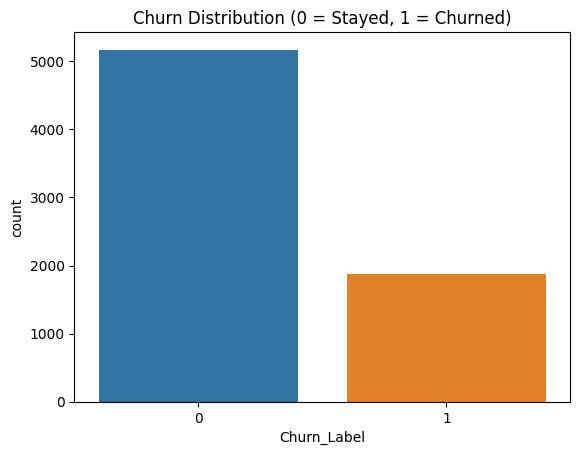

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(data=master_df, x="Churn_Label")
plt.title("Churn Distribution (0 = Stayed, 1 = Churned)")
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


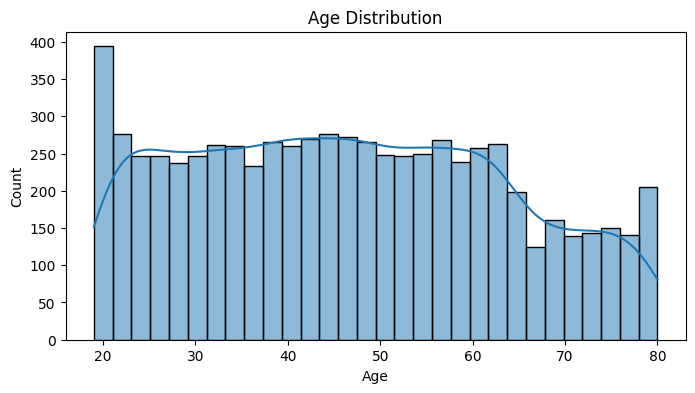

In [35]:
plt.figure(figsize=(8,4))
sns.histplot(master_df["Age"], bins=30, kde=True)
plt.title("Age Distribution")
plt.show()


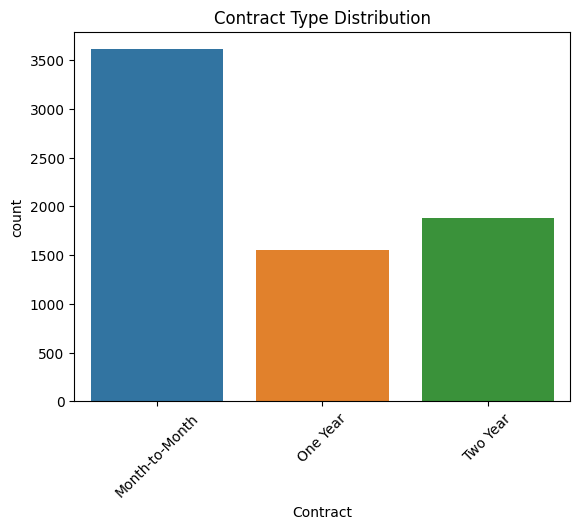

In [36]:
sns.countplot(data=master_df, x="Contract")
plt.title("Contract Type Distribution")
plt.xticks(rotation=45)
plt.show()


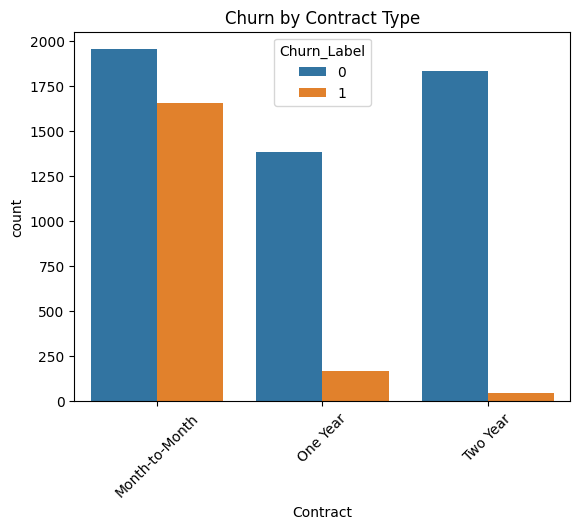

In [37]:
sns.countplot(data=master_df, x="Contract", hue="Churn_Label")
plt.title("Churn by Contract Type")
plt.xticks(rotation=45)
plt.show()


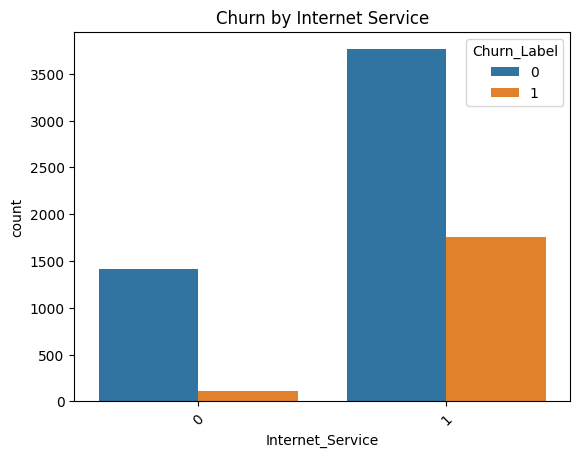

In [38]:
sns.countplot(data=master_df, x="Internet_Service", hue="Churn_Label")
plt.title("Churn by Internet Service")
plt.xticks(rotation=45)
plt.show()


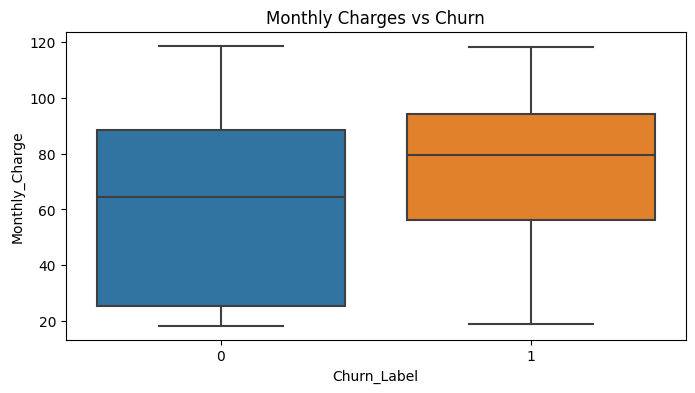

In [39]:
plt.figure(figsize=(8,4))
sns.boxplot(data=master_df, x="Churn_Label", y="Monthly_Charge")
plt.title("Monthly Charges vs Churn")
plt.show()


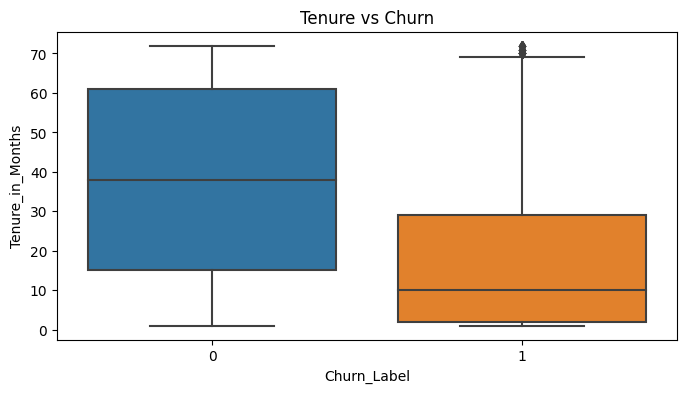

In [40]:
plt.figure(figsize=(8,4))
sns.boxplot(data=master_df, x="Churn_Label", y="Tenure_in_Months")
plt.title("Tenure vs Churn")
plt.show()


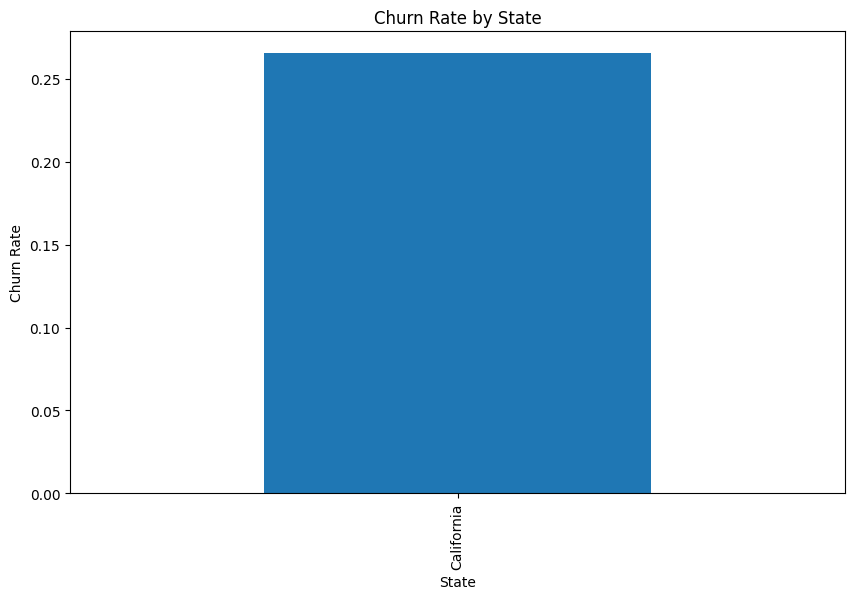

In [41]:
state_churn = master_df.groupby("State")["Churn_Label"].mean().sort_values(ascending=False)

plt.figure(figsize=(10,6))
state_churn.plot(kind="bar")
plt.title("Churn Rate by State")
plt.ylabel("Churn Rate")
plt.show()


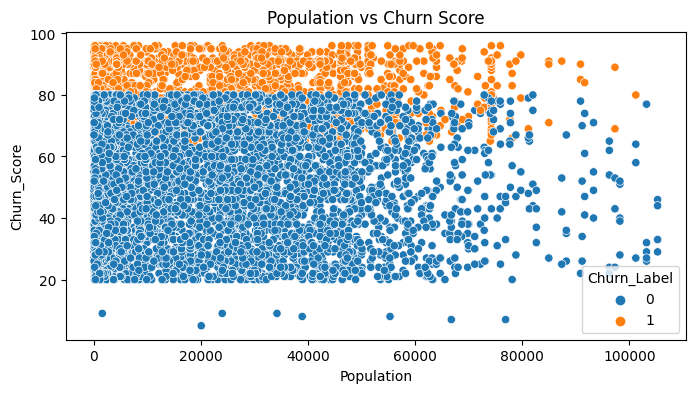

In [42]:
plt.figure(figsize=(8,4))
sns.scatterplot(data=master_df, x="Population", y="Churn_Score", hue="Churn_Label")
plt.title("Population vs Churn Score")
plt.show()


# ***Step 8: Feature Encoding, Train-Test Split, and Model Training***

In [63]:
# Remove true leakage columns only
leakage_cols = ["Churn_Value", "Churn_Score"]

# Prepare feature set (X) and target (y)
X = master_df.drop(columns=leakage_cols + ["Churn_Label", "CustomerID"])
y = master_df["Churn_Label"]


In [64]:
from sklearn.model_selection import train_test_split

# Identify categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# One-hot encoding
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape


((5634, 2834), (1409, 2834))

In [65]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

log_model = LogisticRegression(max_iter=3000)
log_model.fit(X_train, y_train)

y_pred_lr = log_model.predict(X_test)

print("LR Accuracy:", accuracy_score(y_test, y_pred_lr))
print("LR Precision:", precision_score(y_test, y_pred_lr))
print("LR Recall:", recall_score(y_test, y_pred_lr))
print("LR F1:", f1_score(y_test, y_pred_lr))


LR Accuracy: 0.830376153300213
LR Precision: 0.7272727272727273
LR Recall: 0.5775401069518716
LR F1: 0.6438152011922504


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [66]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

svm_model = Pipeline([
    ('scale', StandardScaler()),
    ('svc', SVC(kernel='linear'))
])

svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM Precision:", precision_score(y_test, y_pred_svm))
print("SVM Recall:", recall_score(y_test, y_pred_svm))
print("SVM F1:", f1_score(y_test, y_pred_svm))


SVM Accuracy: 0.943222143364088
SVM Precision: 0.8888888888888888
SVM Recall: 0.8983957219251337
SVM F1: 0.8936170212765958


In [67]:
results = pd.DataFrame({
    "Model": ["Logistic Regression", "SVM (Linear)"],
    "Accuracy": [accuracy_score(y_test, y_pred_lr), accuracy_score(y_test, y_pred_svm)],
    "Precision": [precision_score(y_test, y_pred_lr), precision_score(y_test, y_pred_svm)],
    "Recall": [recall_score(y_test, y_pred_lr), recall_score(y_test, y_pred_svm)],
    "F1 Score": [f1_score(y_test, y_pred_lr), f1_score(y_test, y_pred_svm)]
})

results


,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.830376,0.727273,0.577540,0.643815
1,SVM (Linear),0.943222,0.888889,0.898396,0.893617


# ***Step 9: Final Model Evaluation, Insights, and Project Summary***

In [68]:
import numpy as np
import pandas as pd

# Extract coefficients from linear SVM model inside the pipeline
coefficients = svm_model.named_steps['svc'].coef_.flatten()
feature_names = X.columns

coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": np.abs(coefficients)
})

top_features = coef_df.sort_values(by="Importance", ascending=False).head(15)
top_features


,Feature,Importance
33,Satisfaction_Score,5.539510
11,Number_of_Referrals,1.776313
12,Tenure_in_Months,1.210193
18,Online_Security,1.195109
5,Dependents,0.953316
6,Number_of_Dependents,0.612283
2831,Contract_Two Year,0.601960
17,Avg_Monthly_GB_Download,0.553849
4,Married,0.497292
13,Phone_Service,0.495474


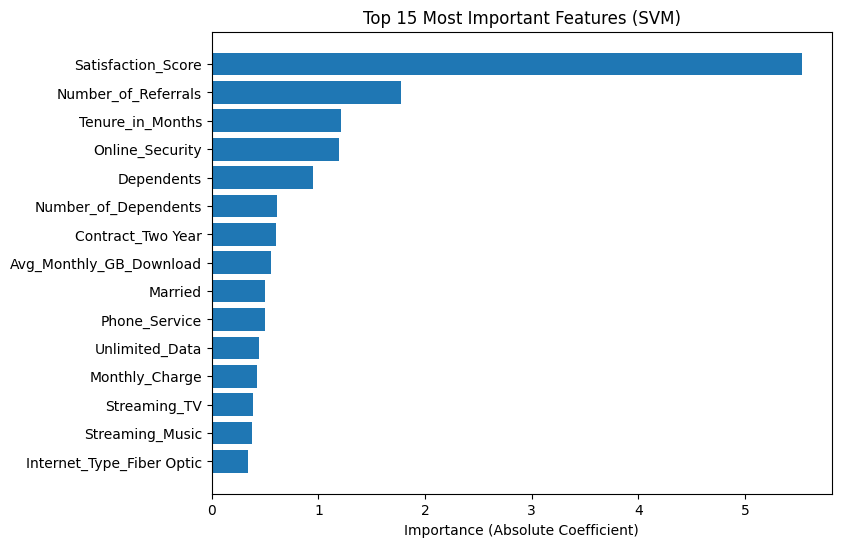

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.barh(top_features["Feature"], top_features["Importance"])
plt.gca().invert_yaxis()
plt.title("Top 15 Most Important Features (SVM)")
plt.xlabel("Importance (Absolute Coefficient)")
plt.show()


In [70]:
import joblib

# Save SVM model
joblib.dump(svm_model, "svm_model.pkl")

# Save feature column names
joblib.dump(list(X.columns), "feature_columns.pkl")

"Model & feature columns saved successfully!"


'Model & feature columns saved successfully!'